In [52]:
import math
import numpy as np

# Constants
rho0 = 1.225  # Sea level air density (kg/m^3)
h = [0, 3000, 12500, 0]  # Altitudes in meters (takeoff, climb, cruise, landing)
Cd0 = 0.021  # Parasitic drag coefficient 
delta = 0.005  # Induced drag correction factor
AR = 4.5 # Effective  Aspect ratio
CL = [1, 0.5, 0.261, 1.7]  # Adjusted Lift coefficients for phases (lower landing CL)
S = 204.41   # Wing area (m^2)
W = 471511.32  # Aircraft weight (N)
gamma = 3 # Climb angle in degrees
v = [72, 110, 290, 55]  # Speeds (m/s) for each phase
e = 0.95 # oswalds efficiency 

# Drag coefficients
Cd = np.array([Cd0 + ((cl ** 2) / (math.pi * AR * e)) * (1 + delta) for cl in CL])
cd = ["Takeoff", "Climb", "Cruise", "Landing"]
for i, cd in enumerate(cd):
    print(f"{cd} Cd: {Cd[i]:.2f} ")

# Density function
def rho(h):
    rho0 = 1.225
    sea_level_temp = 288.15
    lapse_rate = -0.0065
    R = 287.05
    g = 9.80665
    tropopause_height = 11000

    if isinstance(h, (list, np.ndarray)):
        return np.array([rho(alt) for alt in h])
    if h <= tropopause_height:
        temperature = sea_level_temp + lapse_rate * h
        return rho0 * (temperature / sea_level_temp) ** (-g / (lapse_rate * R))
    else:
        temperature = sea_level_temp + lapse_rate * tropopause_height
        exp_factor = (-g * (h - tropopause_height)) / (R * temperature)
        return rho0 * (temperature / sea_level_temp) ** (-g / (lapse_rate * R)) * math.exp(exp_factor)

# Dynamic pressure calculation
def dynamic_pressure(V, h):
    densities = rho(h)
    return 0.5 * densities * np.array(V)**2

# Drag 
def Drag (Cd, q, S):
    return Cd * q * S

# Additional Drag  for climb
def Drag_climb(W, gamma):
    gamma_rad = math.radians(gamma)
    return W * math.sin(gamma_rad)

# Drag  calculations for each segment
q = dynamic_pressure(v, h)  # Dynamic pressure for each segment
T = [Drag(Cd[i], q[i], S) for i in range(len(v))]
T[1] += Drag_climb(W, gamma)  # Add climb-specific Drag 

# Segment Results
segments = ["Takeoff", "Climb", "Cruise", "Landing"]
print("Dynamic Pressures for each segment:")
for i, segment in enumerate(segments):
    print(f"{segment}: {q[i]:.2f} Pa")

# Output Drag  for each phase
for i, segment in enumerate(segments):
    print(f"{segment} Drag : {T[i]:.2f} N")
# Additional checks for drag and thrust comparison
#print("\nClimb vs Landing Drag Comparison:")
#print(f"Climb Drag: {T[1]:.2f} N")
#print(f"Landing Drag: {T[3]:.2f} N")


Takeoff Cd: 0.10 
Climb Cd: 0.04 
Cruise Cd: 0.03 
Landing Cd: 0.24 
Dynamic Pressures for each segment:
Takeoff: 3175.20 Pa
Climb: 5127.95 Pa
Cruise: 9081.90 Pa
Landing: 1852.81 Pa
Takeoff Drag : 62198.24 N
Climb Drag : 66298.79 N
Cruise Drag : 48448.30 N
Landing Drag : 89858.61 N


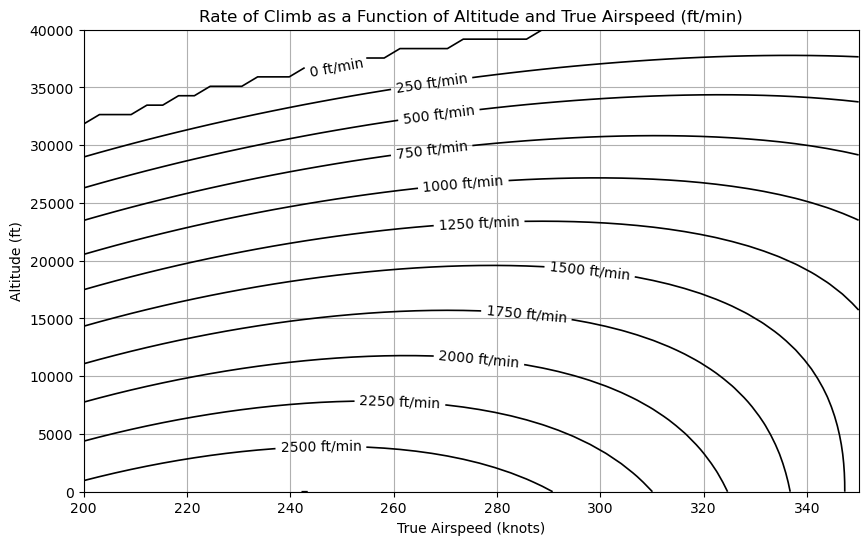

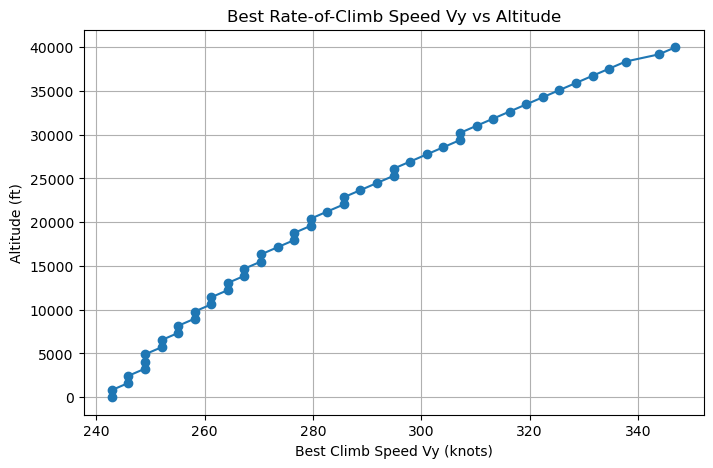

Fuel burned during climb: 2242.86 kg
Fuel burned during cruise: 20198.39 kg
Fuel burned during descent: 880.63 kg


In [114]:
import numpy as np
import matplotlib.pyplot as plt

# ISA Density function
def density(alt_ft):
    alt_m = alt_ft * 0.3048  
    T0 = 288.15  # K
    p0 = 101325  # Pa
    L = 0.0065   # K/m
    g = 9.80665  # m/s²
    R = 287.058  # J/(kg*K)

    T = T0 - L * alt_m  
    p = p0 * (T / T0) ** (g / (R * L))
    rho = p / (R * T)
    return rho

# Aircraft & Performance Parameters
rho0 = 1.225  # Sea-level air density (kg/m³)
W_lbf = 106000  
W = W_lbf * 4.44822  # Weight in Newtons
S_ft2 = 2011.66722       
S = S_ft2 * 0.092903  # Wing area in m²
T0_lbf =21970    # static thrust in lbf 
T0 = T0_lbf * 4.44822  # Sea-level thrust (N)
C_D0 = 0.02  # Zero-lift drag coefficient
A = 4.5  # Aspect ratio
e = 0.95  # Oswald efficiency factor

# Engine Parameters
TSFC0_takeoff = 0.37 / 3600  # Sea-level TSFC for takeoff (1/s)
TSFC0_cruise = 0.51 / 3600  # Sea-level TSFC for cruise (1/s)

altitudes = np.linspace(0, 40000, 50)  # Altitudes (ft)
airspeeds_knots = np.linspace(200, 350, 50)  # True Airspeeds (knots)
ROC = np.zeros((len(altitudes), len(airspeeds_knots)))

# Compute Rate of Climb (ROC)
for i, alt in enumerate(altitudes):
    rho = density(alt)
    T_available = T0 * (rho / rho0) ** 0.7  # Turbofan thrust decay
    
    for j, tas_knots in enumerate(airspeeds_knots):
        V = tas_knots * 0.514444  # Convert knots to m/s
        Mach = V / np.sqrt(1.4 * 287 * (288.15 - 0.0065 * alt * 0.3048))
        
        # Compute TSFC Correction for Climb
        TSFC_climb = TSFC0_takeoff * (rho / rho0) ** -0.3 * (1 + 0.2 * Mach)
        
        # Compute Lift Coefficient (C_L)
        C_L = (2 * W) / (rho * V**2 * S)

        # Compute Drag Coefficient (C_D)
        C_D = C_D0 + (C_L**2) / (np.pi * A * e)

        # Compute Drag Force (D)
        D = 0.5 * rho * V**2 * S * C_D  

        # Compute Excess Thrust (T - D)
        excess_thrust = T_available - D

        # Compute ROC in m/s
        roc_ms = V * excess_thrust / W
        roc_ft_min = roc_ms * 3.28084 * 60  # Convert to ft/min

        ROC[i, j] = max(roc_ft_min, 0)  # No negative ROC values

# Plot Results
plt.figure(figsize=(10, 6))
contour = plt.contour(airspeeds_knots, altitudes, ROC, levels=12, colors='black', linewidths=1.2)
plt.clabel(contour, inline=True, fontsize=10, fmt='%1.0f ft/min')
plt.xlabel('True Airspeed (knots)')
plt.ylabel('Altitude (ft)')
plt.title('Rate of Climb as a Function of Altitude and True Airspeed (ft/min)')
plt.grid(True)
plt.show()

# Find Best Climb Speed (Vy) for each altitude
Vy_list = []
for i, alt in enumerate(altitudes):
    best_speed_idx = np.argmax(ROC[i, :])
    Vy_list.append(airspeeds_knots[best_speed_idx])

# Plot Best Climb Speed (Vy) vs Altitude
plt.figure(figsize=(8, 5))
plt.plot(Vy_list, altitudes, marker='o', linestyle='-')
plt.xlabel('Best Climb Speed Vy (knots)')
plt.ylabel('Altitude (ft)')
plt.title('Best Rate-of-Climb Speed Vy vs Altitude')
plt.grid(True)
plt.show()

# Compute Fuel Burn using Breguet Range Equation for Different Phases
R_climb = 740800  # Climb range in meters 5% of the total range 
R_cruise =13037080# Cruise range in meters 88% 
R_descent = 889000 # Descent range in meters 6%
LD_max = 15 #  L/D
Wi = W  # Initial weight

# TSFC for Cruise and Descent
TSFC_cruise = TSFC0_cruise * 0.85  # Cruise correction
TSFC_descent = TSFC0_cruise * 0.75  # Descent correction

# Fuel Burn Calculation
fuel_burn_fraction_climb = 1 - np.exp(-TSFC_climb * R_climb / (V * LD_max))
fuel_burn_fraction_cruise = 1 - np.exp(-TSFC_cruise * R_cruise / (V * LD_max))
fuel_burn_fraction_descent = 1 - np.exp(-TSFC_descent * R_descent / (V * LD_max))

Wf_climb = Wi * (1 - fuel_burn_fraction_climb)
Wf_cruise = Wf_climb * (1 - fuel_burn_fraction_cruise)
Wf_descent = Wf_cruise * (1 - fuel_burn_fraction_descent)

fuel_burned_climb_kg = (Wi - Wf_climb) / 9.81
fuel_burned_cruise_kg = (Wf_climb - Wf_cruise) / 9.81
fuel_burned_descent_kg = (Wf_cruise - Wf_descent) / 9.81

print(f"Fuel burned during climb: {fuel_burned_climb_kg:.2f} kg")
print(f"Fuel burned during cruise: {fuel_burned_cruise_kg:.2f} kg")
print(f"Fuel burned during descent: {fuel_burned_descent_kg:.2f} kg")


In [118]:
import numpy as np
#still iterating 
# Engine & Fuel Parameters
TSFC_static = 0.000011  # kg/N/s for PW1521G
altitude_corrections = [1.0, 0.95, 0.9, 1.0]  # Takeoff, climb, cruise, landing
mach_corrections = [1.0, 0.9, 0.85, 1.0]  # Takeoff, climb, cruise, landing
fuel_density = 0.8  # kg/L (Jet-A)
MTOW_lbs = 106000  # Maximum Takeoff Weight in pounds
MTOW_kg = MTOW_lbs * 0.453592  # Convert to kg

# Flight Parameters
durations = [120, 900, 55795, 600]  # Time in seconds (Takeoff, Climb, Cruise, Landing)
thrusts = [210815.14, 117166.42, 51745.07, 73303.73]  # Corrected thrust values (N per phase)
cruise_speed = 290  # Cruise speed in m/s (450 knots)
cruise_range = 7040 * 1852  # Cruise range in meters (7040  nautical miles)
L_D_ratio = 11  # Lift-to-drag ratio during cruise

# Function to compute fuel burn using Breguet equation for cruise
def compute_fuel_burn(tsfc, thrusts, durations, altitude_corrections, mach_corrections, cruise_speed, cruise_range, L_D_ratio):
    fuel_burn = []
    initial_weight = MTOW_kg  # Start with MTOW

    for i, phase in enumerate(["Takeoff", "Climb", "Cruise", "Landing"]):
        if phase == "Cruise":
            # Use Breguet equation for cruise
            g = 9.80665  # Gravitational acceleration (m/s²)
            tsfc_corrected = tsfc * altitude_corrections[i] * mach_corrections[i]
            exponent = (-cruise_range * g * tsfc_corrected) / (cruise_speed * L_D_ratio)
            final_weight = initial_weight * np.exp(exponent)
            fuel_burn_phase = initial_weight - final_weight
            initial_weight = final_weight  # Update initial weight for next phase
        else:
            # Use thrust and duration for other phases
            tsfc_corrected = tsfc * altitude_corrections[i] * mach_corrections[i]
            fuel_rate = tsfc_corrected * thrusts[i]  # kg/s
            fuel_burn_phase = fuel_rate * durations[i]  # kg
            initial_weight -= fuel_burn_phase  # Update initial weight for next phase

        fuel_burn.append(fuel_burn_phase)

    return fuel_burn

# Calculate total fuel burn per phase
fuel_burn_per_phase = compute_fuel_burn(TSFC_static, thrusts, durations, altitude_corrections, mach_corrections, cruise_speed, cruise_range, L_D_ratio)
total_fuel_burn = sum(fuel_burn_per_phase)

# Convert to fuel volume (liters)
fuel_volume_liters = total_fuel_burn / fuel_density
fuel_volume_gallons = fuel_volume_liters / 3.785  # Convert to US gallons

# Print results
phases = ["Takeoff", "Climb", "Cruise", "Landing"]
for i, phase in enumerate(phases):
    print(f"{phase}:")
    print(f"  Fuel Burn: {fuel_burn_per_phase[i]:.2f} kg")

print(f"\nTotal Fuel Burn: {total_fuel_burn:.2f} kg")
print(f"Fuel Volume: {fuel_volume_liters:.2f} L ({fuel_volume_gallons:.2f} US gallons)")
print(f"Maximum Takeoff Weight (MTOW): {MTOW_kg:.2f} kg ({MTOW_lbs} lbs)")

Takeoff:
  Fuel Burn: 278.28 kg
Climb:
  Fuel Burn: 991.76 kg
Cruise:
  Fuel Burn: 13401.68 kg
Landing:
  Fuel Burn: 483.80 kg

Total Fuel Burn: 15155.51 kg
Fuel Volume: 18944.39 L (5005.12 US gallons)
Maximum Takeoff Weight (MTOW): 48080.75 kg (106000 lbs)


Takeoff: 210815.14 N (total for 2 engines)
Climb: 117166.42 N (total for 2 engines)
Cruise: 51745.07 N (total for 2 engines)
Landing: 73303.73 N (total for 2 engines)


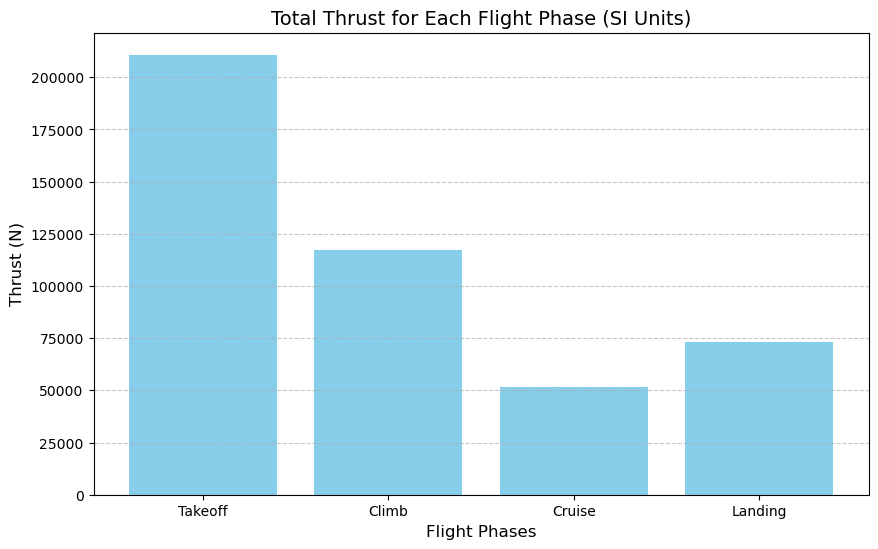

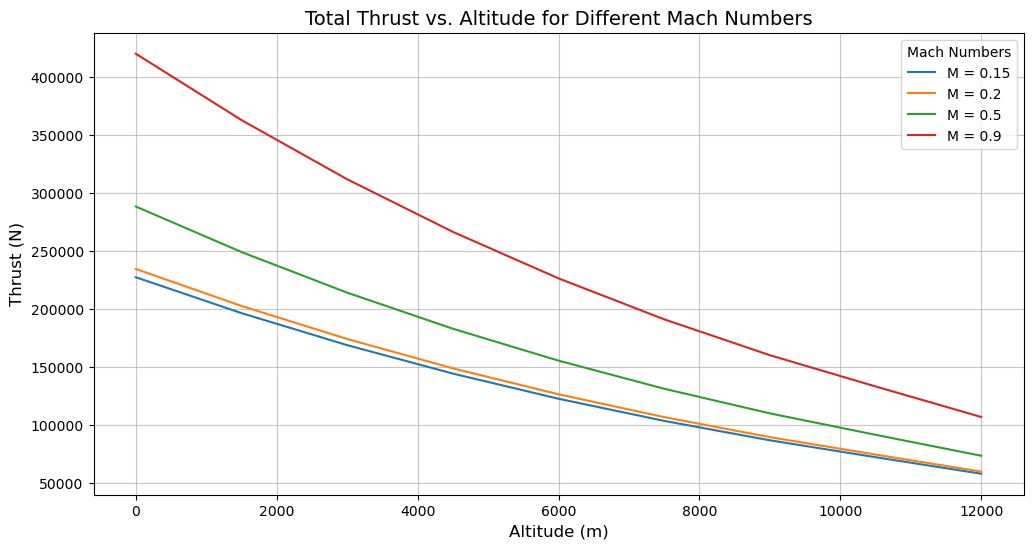

In [125]:
import math
import matplotlib.pyplot as plt

def high_bypass_turbofan_thrust(F0, TR, H, M, deltaOAT_C):
    """
    Calculate thrust for a high bypass ratio turbofan engine as a function of altitude and Mach number.
    
    Parameters:
        F0 (float): Engine thrust at sea level and ISA, in N.
        TR (float): Throttle ratio.
        H (float): Altitude in meters.
        M (float): Mach number.
        deltaOAT_C (float): Deviation from ISA temperature in °C.
    
    Returns:
        float: Thrust in N.
    """
    # Constants
    T0 = 288.15  # ISA sea level temperature in Kelvin
    P0 = 101325  # ISA sea level pressure in Pa
    R = 287.05  # Specific gas constant for air in J/(kg·K)
    gamma_air = 1.4  # Ratio of specific heats
    a0 = math.sqrt(gamma_air * R * T0)  # Speed of sound at sea level (m/s)
    
    # Atmospheric properties
    if H <= 11000:  # Troposphere
        T = T0 + (-0.0065 * H) + deltaOAT_C  # Temperature at altitude
        P = P0 * (T / T0) ** (-9.80665 / (-0.0065 * R))  # Pressure at altitude
    else:  # Stratosphere (constant temperature)
        T = T0 - 0.0065 * 11000 + deltaOAT_C
        P = P0 * (T / T0) ** (-9.80665 / (-0.0065 * R)) * math.exp(
            -9.80665 * (H - 11000) / (R * T)
        )
    
    rho = P / (R * T)  # Air density in kg/m³
    sigma = rho / 1.225  # Density ratio
    
    # Pressure ratio
    delta = sigma * (1 + 0.2 * M ** 2) ** 3.0  # Adjusted exponent for more realistic scaling
    
    # Temperature ratio
    theta = T / T0 * (1 + 0.2 * M ** 2)
    
    # High Bypass Ratio Turbofan Calculation
    thrust = F0 * TR * delta * (1 + 0.40 * math.sqrt(M))  # Reduced Mach effect coefficient
    
    return max(thrust, 0)  # Ensure thrust is not negative

# Flight phase-specific parameters in SI units
flight_phases = {
    "Takeoff": {"H": 0, "M": 0.2, "TR": 0.9, "deltaOAT_C": 0},  # Reduced TR for realistic takeoff thrust
    "Climb": {"H": 5000, "M": 0.3, "TR": 0.85, "deltaOAT_C": -5},
    "Cruise": {"H": 12500, "M": 0.9, "TR": 0.65, "deltaOAT_C": -10},
    "Landing": {"H": 0, "M": 0.15, "TR": 0.3, "deltaOAT_C": 5},
}

# Constants
F0 = 97000 # Sea level thrust per engine in N
num_engines = 2  # Number of engines

# Calculate thrust for each phase
thrust_results = []
phases = []
for phase, params in flight_phases.items():
    H = params["H"]
    M = params["M"]
    TR = params["TR"]
    deltaOAT_C = params["deltaOAT_C"]
    
    thrust = high_bypass_turbofan_thrust(F0, TR, H, M, deltaOAT_C)
    total_thrust = thrust * num_engines  # Total thrust for two engines
    thrust_results.append(total_thrust)
    phases.append(phase)
    print(f"{phase}: {total_thrust:.2f} N (total for {num_engines} engines)")

#  Bar plot for thrust in each phase
plt.figure(figsize=(10, 6))
plt.bar(phases, thrust_results, color='skyblue')
plt.title("Total Thrust for Each Flight Phase (SI Units)", fontsize=14)
plt.ylabel("Thrust (N)", fontsize=12)
plt.xlabel("Flight Phases", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#  Thrust vs. Altitude and Mach Number
altitudes = range(0, 12500, 1500)  # Altitudes from 0 to 12,500 m
mach_numbers = [0.15, 0.2, 0.5, 0.9]  #  (Landing, Takeoff, Climb, Cruise)

plt.figure(figsize=(12, 6))
for M in mach_numbers:
    thrusts = [
        high_bypass_turbofan_thrust(F0, 1.0, H, M, 0) * num_engines for H in altitudes
    ]
    plt.plot(altitudes, thrusts, label=f"M = {M}")

plt.title("Total Thrust vs. Altitude for Different Mach Numbers", fontsize=14)
plt.ylabel("Thrust (N)", fontsize=12)
plt.xlabel("Altitude (m)", fontsize=12)
plt.legend(title="Mach Numbers", fontsize=10)
plt.grid(alpha=0.7)
plt.show()



Mission: Passenger
Takeoff Thrust: 174459.19 N
Climb Thrust: 151641.60 N
Cruise Thrust: 49734.78 N
Landing Thrust: 101474.84 N

Mission: Aspen
Takeoff Thrust: 152234.28 N
Climb Thrust: 139282.88 N
Cruise Thrust: 43257.81 N
Landing Thrust: 96015.32 N

Mission: Napa
Takeoff Thrust: 185000.00 N
Climb Thrust: 148258.75 N
Cruise Thrust: 43257.81 N
Landing Thrust: 120854.83 N


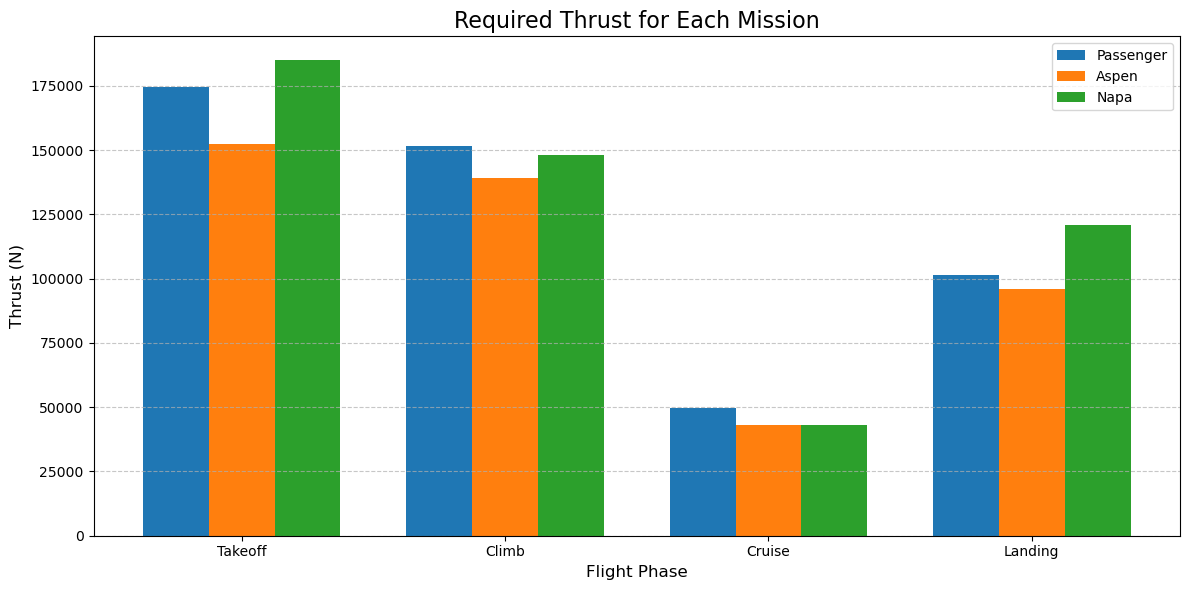

In [119]:
import matplotlib.pyplot as plt
import math
import numpy as np

# Constants
rho_sl = 1.225  # Air density at sea level (kg/m³)
g = 9.81  # Gravitational acceleration (m/s²)

# Inputs 
wing_area = 182.56  # Wing area (m²)
Cl = [1, 0.6, 0.261, 1.5]  # CL for takeoff, climb, cruise, landing
Cd = [0.23, 0.10, 0.03, 0.30]  # CD for takeoff, climb, cruise, landing
gamma_climb = 3  # Climb angle in degrees

# Mission-specific weights (in Newtons)
weights = {
    "Passenger": 471511.32,
    "Aspen": 411444.0,
    "Napa": 500000.0,
}

# Mission-specific altitudes and speeds (m and m/s)
missions = {
    "Passenger": {"altitude": [0, 3000, 12500, 0], "speeds": [72, 140, 290, 55]},
    "Aspen": {"altitude": [0, 2500, 12000, 0], "speeds": [69, 130, 260, 53.5]},
    "Napa": {"altitude": [0, 2000, 12000, 0], "speeds": [75, 130, 260, 60.0227]},
}

# Phases
phases = ["Takeoff", "Climb", "Cruise", "Landing"]

# Functions
def air_density(h):
    """ISA atmosphere model for air density."""
    if h <= 11000:
        return rho_sl * (1 - 0.0065 * h / 288.15) ** 5.256
    else:
        T = 216.65  # Constant temp in stratosphere
        rho_11km = rho_sl * (1 - 0.0065 * 11000 / 288.15) ** 5.256
        return rho_11km * math.exp(-g * (h - 11000) / (287.05 * T))

def dynamic_pressure(rho, V):
    """Calculate dynamic pressure."""
    return 0.5 * rho * V**2

def thrust_required(CD, q, S):
    """Calculate thrust required to overcome drag."""
    return CD * q * S

def climb_thrust(weight, gamma_deg):
    """Calculate thrust required for climb."""
    gamma_rad = math.radians(gamma_deg)
    return weight * math.sin(gamma_rad)

# Store thrust results for visualization
thrust_results = {mission: [] for mission in missions}

# Loop through missions
for mission, data in missions.items():
    print(f"\nMission: {mission}")
    W = weights[mission]
    altitudes = data["altitude"]
    speeds = data["speeds"]

    for i, phase in enumerate(phases):
        rho = air_density(altitudes[i])
        q = dynamic_pressure(rho, speeds[i])

        if phase == "Takeoff":
            T = 0.37 * W  # More realistic takeoff T/W ratio
        elif phase == "Climb":
            T_drag = thrust_required(Cd[i], q, wing_area)
            T_climb = climb_thrust(W, gamma_climb)
            T = max(T_drag, T_climb)  # Choose the dominant factor
        else:
            T = thrust_required(Cd[i], q, wing_area)

        thrust_results[mission].append(T)
        print(f"{phase} Thrust: {T:.2f} N")

# Visualization of results 
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(phases))
width = 0.25  # Bar width

# Plot each mission's thrust for all phases
for i, mission in enumerate(missions):
    ax.bar(x + i * width, thrust_results[mission], width, label=mission)

ax.set_title("Required Thrust for Each Mission", fontsize=16)
ax.set_xlabel("Flight Phase", fontsize=12)
ax.set_ylabel("Thrust (N)", fontsize=12)
ax.set_xticks(x + width)
ax.set_xticklabels(phases, fontsize=10)
ax.legend(fontsize=10)
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()



Mission: Passenger
Takeoff:
  Corrected Thrust: 194000.00 N
  Thrust Margin: 19540.81 N
  Fuel Burn: 172.71 kg
Climb:
  Corrected Thrust: 197123.29 N
  Thrust Margin: 45481.69 N
  Fuel Burn: 1484.22 kg
Cruise:
  Corrected Thrust: 204018.85 N
  Thrust Margin: 154284.07 N
  Fuel Burn: 29446.10 kg
Landing:
  Corrected Thrust: 194000.00 N
  Thrust Margin: 92525.16 N
  Fuel Burn: 669.73 kg

Mission: Aspen
Takeoff:
  Corrected Thrust: 194000.00 N
  Thrust Margin: 41765.72 N
  Fuel Burn: 150.71 kg
Climb:
  Corrected Thrust: 197368.62 N
  Thrust Margin: 58085.74 N
  Fuel Burn: 1816.07 kg
Cruise:
  Corrected Thrust: 214187.64 N
  Thrust Margin: 170929.83 N
  Fuel Burn: 3990.16 kg
Landing:
  Corrected Thrust: 204018.85 N
  Thrust Margin: 108003.53 N
  Fuel Burn: 1222.63 kg

Mission: Napa
Takeoff:
  Corrected Thrust: 189421.99 N
  Thrust Margin: 4421.99 N
  Fuel Burn: 186.30 kg
Climb:
  Corrected Thrust: 191677.81 N
  Thrust Margin: 43419.06 N
  Fuel Burn: 2467.40 kg
Cruise:
  Corrected Thrust: 

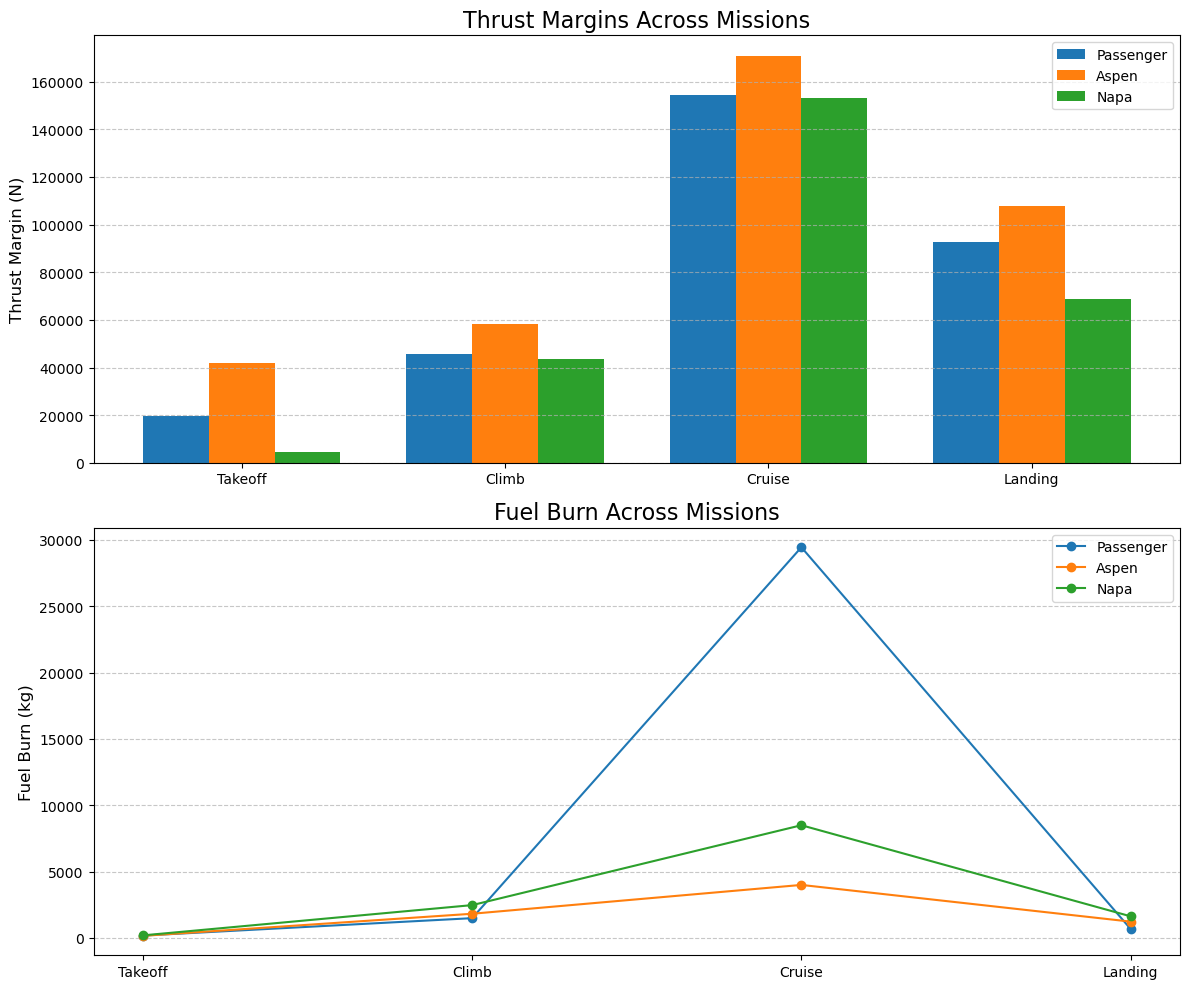

In [120]:
import matplotlib.pyplot as plt
import numpy as np
#still checking this 
# Constants
T_static_per_engine = 97000  # Static thrust per engine (N)
engines = 2  # Number of engines
T_static_total = T_static_per_engine * engines  # Total available thrust (N)
T0 = 288.15  # Standard sea-level temperature (K)
rho_sl = 1.225  # Sea level air density (kg/m³)
TSFC_static = 0.000011  # Static TSFC (kg/N/s)
phases = ["Takeoff", "Climb", "Cruise", "Landing"]

# Mission-specific inputs
missions = {
    "Passenger": {
        "altitude": [0, 5000, 12500, 0],
        "speeds": [70, 140, 290, 60],
        "temperatures": [288.15, 281.65, 268.15, 288.15],
        "thrust_required": [174459.19, 151641.60, 49734.78, 101474.84],
        "durations": [90, 900, 55795, 600]
    },
    "Aspen": {
        "altitude": [0, 2500, 11000, 0],
        "speeds": [65, 130, 230, 55],
        "temperatures": [288.15, 281.15, 250.15, 268.15],
        "thrust_required": [152234.28, 139282.88, 43257.81, 96015.32],
        "durations": [90, 1200, 9000, 1200] 
    },
    "Napa": {
        "altitude": [0, 2000, 12500, 0],
        "speeds": [75, 150, 240, 70],
        "temperatures": [298.15, 293.15, 283.15, 298.15],
        "thrust_required": [185000.00, 148258.75, 43257.81, 120854.83],
        "durations": [90, 1500, 18000, 1200]
    },
}

# Store results 
thrust_margins = {mission: [] for mission in missions}
fuel_burns = {mission: [] for mission in missions}

# Loop through missions
for mission, data in missions.items():
    print(f"\nMission: {mission}")
    thrust_required = data["thrust_required"]
    temperatures = data["temperatures"]
    durations = data["durations"]

    for i, phase in enumerate(phases):
        # Corrected Available Thrust (ISA Model)
        T_corrected = T_static_total * (temperatures[i] / T0) ** -0.7
        
        # Thrust margin
        margin = T_corrected - thrust_required[i]
        thrust_margins[mission].append(margin)
        
        # Corrected TSFC
        TSFC_corrected = TSFC_static * (temperatures[i] / T0) ** 0.5
        fuel_burn = TSFC_corrected * thrust_required[i] * durations[i]
        fuel_burns[mission].append(fuel_burn)

        print(f"{phase}:")
        print(f"  Corrected Thrust: {T_corrected:.2f} N")
        print(f"  Thrust Margin: {margin:.2f} N")
        print(f"  Fuel Burn: {fuel_burn:.2f} kg")

# Visualization
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

# X-axis positions
x = np.arange(len(phases))
width = 0.25  # Bar width

# Plot Thrust Margins
for i, mission in enumerate(missions):
    axs[0].bar(x + i * width, thrust_margins[mission], width, label=mission)
axs[0].set_title("Thrust Margins Across Missions", fontsize=16)
axs[0].set_ylabel("Thrust Margin (N)", fontsize=12)
axs[0].set_xticks(x + width * (len(missions) - 1) / 2)
axs[0].set_xticklabels(phases)
axs[0].legend(fontsize=10)
axs[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot Fuel Burn
for mission in missions:
    axs[1].plot(phases, fuel_burns[mission], marker='o', label=mission)
axs[1].set_title("Fuel Burn Across Missions", fontsize=16)
axs[1].set_ylabel("Fuel Burn (kg)", fontsize=12)
axs[1].legend(fontsize=10)
axs[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [64]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact

# Constants for the design
MTOW = 106000  # Maximum Takeoff Weight (lbs)
OEW = 52886.46  # Operating Empty Weight (lbs)
MFW = 49013.54  # Maximum Fuel Weight (lbs)
MZFW = MTOW - MFW  # Maximum Zero Fuel Weight
MPL = MZFW - OEW  # Maximum Payload (lbs)

# Breguet Range Function with Updated Formula
def breguet_range(Wi, Wf, V, LbyD, CT):
    return V * (LbyD / CT) * np.log(Wi / Wf) / 6076  # Range in nmi

# Payload-Range Diagram Function
def payload_range_diagram(CT_hr, LbyD, V_knots):
    CT = CT_hr / 3600  # Convert TSFC to per second
    V = V_knots * 1.68781  # Convert knots to ft/s
    
    # Point A: Max Payload, zero range
    R_A = 0
    Payload_A = MPL

    # Point B: Max Payload, range with full fuel burned
    Wi_B = OEW + MPL + MFW
    Wf_B = OEW + MPL
    R_B = breguet_range(Wi_B, Wf_B, V, LbyD, CT)
    Payload_B = MPL

    # Point C: Zero Payload, max range
    Wi_C = MTOW
    Wf_C = OEW
    R_C = breguet_range(Wi_C, Wf_C, V, LbyD, CT)
    Payload_C = 0

    # Point D: Partial Payload, range with max fuel burned
    Payload_D = MPL / 2
    Wi_D = OEW + Payload_D + MFW
    Wf_D = OEW + Payload_D
    R_D = breguet_range(Wi_D, Wf_D, V, LbyD, CT)

    # Plot the Payload-Range Diagram
    ranges = [R_A, R_B, R_D, R_C]
    payloads = [Payload_A, Payload_B, Payload_D, Payload_C]

    plt.figure(figsize=(10, 6))
    plt.plot(ranges, payloads, marker='o', linestyle='-', color='blue', label='Payload-Range Curve')
    plt.title("Payload-Range Diagram", fontsize=16)
    plt.xlabel("Range (nmi)", fontsize=14)
    plt.ylabel("Payload (lbs)", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)

    # points on the diagram 
    plt.annotate(f"A (0, {int(Payload_A)})", (R_A, Payload_A), textcoords="offset points", xytext=(-15, 5), fontsize=10, color='red')
    plt.annotate(f"B ({int(R_B)}, {int(Payload_B)})", (R_B, Payload_B), textcoords="offset points", xytext=(-15, 5), fontsize=10, color='red')
    plt.annotate(f"D ({int(R_D)}, {int(Payload_D)})", (R_D, Payload_D), textcoords="offset points", xytext=(-15, 5), fontsize=10, color='red')
    plt.annotate(f"C ({int(R_C)}, {int(Payload_C)})", (R_C, Payload_C), textcoords="offset points", xytext=(-15, 5), fontsize=10, color='red')

    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return R_B, R_D, R_C
# Interactive Sliders to optimise parameters 
interact(payload_range_diagram, 
         CT_hr=(0.4, 0.6, 0.01),  # Select CT directly as lb/lbf/hr
         LbyD=(9, 12, 0.1), 
         V_knots=(450, 600, 5));


interactive(children=(FloatSlider(value=0.49, description='CT_hr', max=0.6, min=0.4, step=0.01), FloatSlider(v…

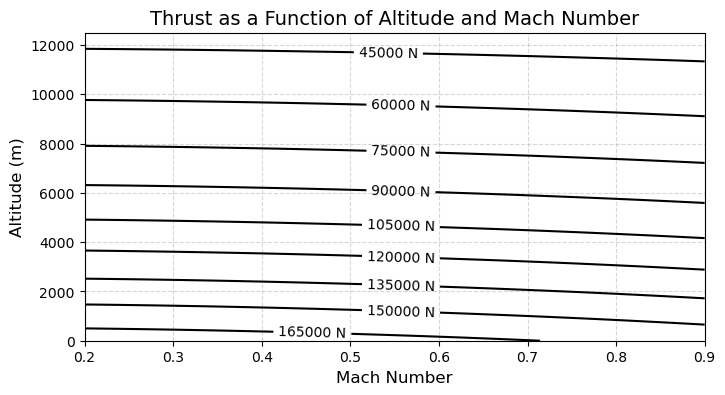

In [73]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
rho_sl = 1.225  # Air density at sea level (kg/m^3)
T_sl = 173868.15   # Sea-level thrust (N) for the engine
gamma = 1.4     # Ratio of specific heats for air
R = 287.05      # Specific gas constant for air (J/kg·K)
T0 = 288.15     # Sea-level standard temperature (K)
L = 0.0065      # Temperature lapse rate (K/m)
P0 = 101325     # Sea-level pressure (Pa)
g = 9.81        # Gravity (m/s^2)

# Altitude and Mach ranges
altitudes = np.linspace(0, 12500, 50)  # Altitude range: 0 to 12.5 km
mach_numbers = np.linspace(0.2, 0.9, 50)  # Mach range: 0.2 to 0.9

# Function to calculate air density at a given altitude (ISA model)
def air_density(altitude):
    if altitude < 11000:  # Troposphere
        T = T0 - L * altitude
        P = P0 * (1 - L * altitude / T0) ** (g / (R * L))
        rho = P / (R * T)
    else:  # Simplified model for stratosphere
        T = T0 - L * 11000
        P = P0 * (1 - L * 11000 / T0) ** (g / (R * L)) * np.exp(-g * (altitude - 11000) / (R * T))
        rho = P / (R * T)
    return rho

# Function to calculate thrust lapse with altitude and Mach
def thrust_lapse(altitude, mach):
    rho = air_density(altitude)
    thrust = T_sl * (rho / rho_sl) * (1 - 0.1 * mach**2)  # Simplified thrust lapse model
    return max(thrust, 0)  # Thrust cannot be negative

# Calculate thrust over altitude and Mach grid
thrust_values = np.zeros((len(altitudes), len(mach_numbers)))

for i, alt in enumerate(altitudes):
    for j, mach in enumerate(mach_numbers):
        thrust_values[i, j] = thrust_lapse(alt, mach)

# Plot the contour plot
X, Y = np.meshgrid(mach_numbers, altitudes)

plt.figure(figsize=(8, 4))
cp = plt.contour(X, Y, thrust_values, levels=10, colors='black', linestyles='solid')
plt.clabel(cp, inline=True, fontsize=10, fmt="%.0f N")  #  labels to contours
plt.title("Thrust as a Function of Altitude and Mach Number", fontsize=14)
plt.xlabel("Mach Number", fontsize=12)
plt.ylabel("Altitude (m)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


Altitude: 0.0 ft, Best Climb Speed (Vy): 160.0 knots, Max ROC: 1893.1725021041975 ft/min
Altitude: 816.3265306122449 ft, Best Climb Speed (Vy): 160.0 knots, Max ROC: 1818.584647362988 ft/min
Altitude: 1632.6530612244899 ft, Best Climb Speed (Vy): 160.0 knots, Max ROC: 1743.8459216395408 ft/min
Altitude: 2448.979591836735 ft, Best Climb Speed (Vy): 160.0 knots, Max ROC: 1668.9274885580435 ft/min
Altitude: 3265.3061224489797 ft, Best Climb Speed (Vy): 160.0 knots, Max ROC: 1593.799391846178 ft/min
Altitude: 4081.6326530612246 ft, Best Climb Speed (Vy): 160.0 knots, Max ROC: 1518.4305024430269 ft/min
Altitude: 4897.95918367347 ft, Best Climb Speed (Vy): 160.0 knots, Max ROC: 1442.7884627312133 ft/min
Altitude: 5714.285714285715 ft, Best Climb Speed (Vy): 160.0 knots, Max ROC: 1366.8396277193456 ft/min
Altitude: 6530.6122448979595 ft, Best Climb Speed (Vy): 160.0 knots, Max ROC: 1290.5490029891116 ft/min
Altitude: 7346.938775510204 ft, Best Climb Speed (Vy): 160.0 knots, Max ROC: 1213.8801

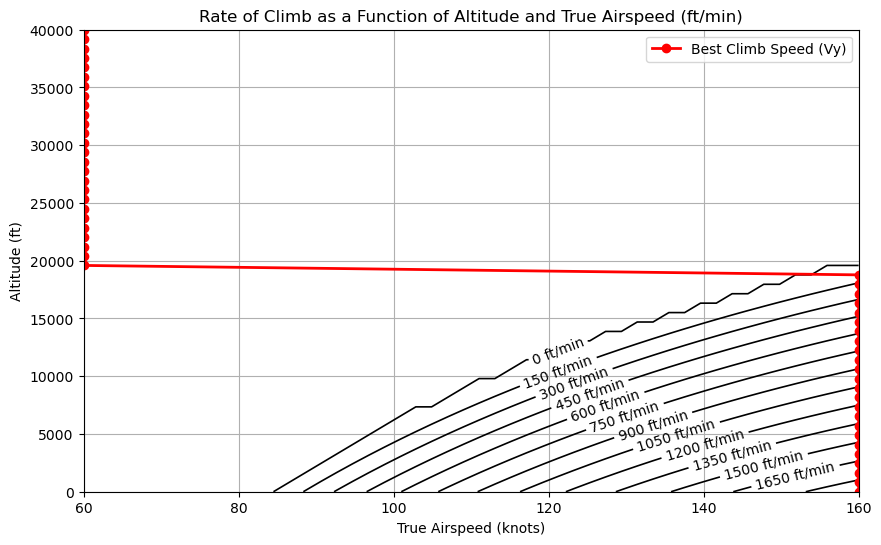

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ISA Density function
def density(alt_ft):
    alt_m = alt_ft * 0.3048  # Convert altitude from feet to meters
    T0 = 288.15  # Sea-level temperature (K)
    p0 = 101325  # Sea-level pressure (Pa)
    L = 0.0065   # Temperature lapse rate (K/m)
    g = 9.80665  # Gravitational acceleration (m/s²)
    R = 287.058  # Specific gas constant for air (J/(kg*K))

    T = T0 - L * alt_m  # Temperature at altitude
    p = p0 * (T / T0) ** (g / (R * L))  # Pressure at altitude
    rho = p / (R * T)  # Density at altitude
    return rho

# Revised Aircraft & Performance Parameters
rho0 = 1.225  # Sea-level air density (kg/m³)
W_lbf = 106000  # Weight in pounds-force
W = W_lbf * 4.44822  # Weight in Newtons
S_ft2 = 2011.66722  # Wing area in square feet
S = S_ft2 * 0.092903  # Wing area in square meters
T0_lbf = 12500  # Sea-level thrust per engine in pounds-force
T0 = T0_lbf * 4.44822  # Sea-level thrust per engine in Newtons
C_D0 = 0.035  # Adjusted zero-lift drag coefficient
A = 4.5  # Aspect ratio
e = 0.95  # Adjusted Oswald efficiency factor

# Altitude and airspeed ranges
altitudes = np.linspace(0, 40000, 50)  # Altitudes (ft)
airspeeds_knots = np.linspace(60, 160, 50)  # Adjusted airspeed range (knots)
ROC = np.zeros((len(altitudes), len(airspeeds_knots)))  # Rate of Climb matrix

# Compute Rate of Climb (ROC)
for i, alt in enumerate(altitudes):
    rho = density(alt)
    T_available = 2 * T0 * (rho / rho0) ** 0.8  # Total thrust from two engines
    
    for j, tas_knots in enumerate(airspeeds_knots):
        V = tas_knots * 0.514444  # Convert knots to m/s

        # Compute Lift Coefficient (C_L)
        C_L = (2 * W) / (rho * V**2 * S)

        # Compute Drag Coefficient (C_D)
        C_D = C_D0 + (C_L**2) / (np.pi * A * e)

        # Compute Drag Force (D)
        D = 0.5 * rho * V**2 * S * C_D

        # Compute Excess Thrust (T - D)
        excess_thrust = T_available - D

        # Compute ROC in m/s
        roc_ms = V * excess_thrust / W
        roc_ft_min = roc_ms * 3.28084 * 60  # Convert to ft/min

        # Store ROC value (ensure no negative values)
        ROC[i, j] = max(roc_ft_min, 0)

# Find Best Climb Speed (Vy) for each altitude
Vy_list = []
for i, alt in enumerate(altitudes):
    best_speed_idx = np.argmax(ROC[i, :])  # Find the index of the maximum ROC
    Vy = airspeeds_knots[best_speed_idx]  # Map the index to airspeed
    Vy_list.append(Vy)
    
    # Debugging output for Vy calculation
   # print(f"Altitude: {alt} ft, Best Climb Speed (Vy): {Vy} knots, Max ROC: {ROC[i, best_speed_idx]} ft/min")

# Plot Results
plt.figure(figsize=(10, 6))

# Contour plot of ROC
contour = plt.contour(airspeeds_knots, altitudes, ROC, levels=12, colors='black', linewidths=1.2)
plt.clabel(contour, inline=True, fontsize=10, fmt='%1.0f ft/min')

# Overlay Vy curve
plt.plot(Vy_list, altitudes, color='red', marker='o', linestyle='-', linewidth=2, label='Best Climb Speed (Vy)')

# Add labels, title, and legend
plt.xlabel('True Airspeed (knots)')
plt.ylabel('Altitude (ft)')
plt.title('Rate of Climb as a Function of Altitude and True Airspeed (ft/min)')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [68]:
# Takeoff distance calculation 

# Known constants
W0 = 471672.55  # Maximum takeoff weight (N)
V_stall = 60 #58.188   Stall speed (m/s)
V_LOF = 1.1 * V_stall  # Liftoff speed (m/s)
V_2 = 1.2 * V_stall  # Climb-out speed (m/s)
print (V_2)
T = 173868.15  # Takeoff thrust (N)
mu = 0.02  # Friction coefficient
rho = 1.225  # Sea level air density (kg/m^3)
#S = 164.9  # Wing area (m^2) Try to keep the value global and do not overwrite it
C_D = 0.20  # Drag coefficient
C_L = 1.0  # Lift coefficient
C_D0 = 0.02  # Zero-lift drag coefficient
C_Lmax = 1.287  # Maximum lift coefficient
g = 9.81  # Gravitational acceleration (m/s^2)
Lambda = 0.161  # Taper ratio
h = 10.668  # Height at which takeoff is completed (m)
A = 4.5  # Aspect ratio

T_bar = 0.75 * ((5 + Lambda) / (4 + Lambda)) * T  # Average thrust (N)
mu_prime = mu + (0.72 * (C_D0 / C_Lmax))  # Effective friction coefficient

# Ground run distance (x_g in meters)
x_g = ((V_LOF**2) / (2 * g)) / ((T_bar / W0) - mu_prime)

# Climb angle (gamma_LOF in radians)
gamma_lof = 0.9 * (T_bar / W0) - (0.3 / (A**0.5))

# Air run distance (x_a in meters)
x_a = ((V_LOF**2) / (2 * g)) + (h / gamma_lof)

# Total takeoff distance (meters)
Takeoff_distance = x_g + x_a

# Print results
print("Takeoff Distance Calculations:")
print(f"Stall Speed (V_stall): {V_stall:.2f} m/s")
print(f"Liftoff Speed (V_LOF): {V_LOF:.2f} m/s")
print(f"Climb-out Speed (V_2): {V_2:.2f} m/s")
print(f"Average Thrust (T_bar): {T_bar:.2f} N")
print(f"Effective Friction Coefficient (mu_prime): {mu_prime:.4f}")
print(f"Ground Run Distance (x_g): {x_g:.2f} m")
print(f"Air Run Distance (x_a): {x_a:.2f} m")
print(f"Total Takeoff Distance: {Takeoff_distance:.2f} m")


72.0
Takeoff Distance Calculations:
Stall Speed (V_stall): 60.00 m/s
Liftoff Speed (V_LOF): 66.00 m/s
Climb-out Speed (V_2): 72.00 m/s
Average Thrust (T_bar): 161740.00 N
Effective Friction Coefficient (mu_prime): 0.0312
Ground Run Distance (x_g): 712.24 m
Air Run Distance (x_a): 285.82 m
Total Takeoff Distance: 998.06 m


In [69]:

import math
# Landing Distance Calculation 
W_landing = 253488.33 # lalnding weight in Newton 
#S = 164.5 # wing area in m
rho = 1.225 # density at sea level in kg/m^3
C_Lmax = 1.287 # maximum wing lift coefficient 
h_ob = 15  # Height of hypothetical object (m)
h_r = 1.5  # Rotation height (m)
gamma_deg = 3  # Descent angle (degrees)
V_stall = ((2*W_landing)/(S*rho*C_Lmax))**0.5
print (V_stall)
V2 = 1.3 *V_stall # Approach speed (m/s)
n = 1.2  # Load factor
V_TD = 1.15*V_stall # Touchdown speed (m/s)
print (V_TD)
a_mean = 2  # Mean deceleration (m/s^2)

def calculate_landing_distance(h_ob, h_r, gamma_deg, V2, n, V_TD, a_mean):
    # Convert angles from degrees to radians
    gamma = math.radians(gamma_deg)

    # Approach distance and time
    x3 = (h_ob - h_r) / math.tan(gamma)
    t3 = x3 / (V2 * math.cos(gamma))

    # Rotation radius, distance, and time
    R = (V2 ** 2) / (9.81 * (n - 1))  # g = 9.81 m/s^2
    x2 = R * math.sin(gamma)
    t2 = (gamma * V2) / (9.81 * (n - 1))

    # Ground run distance
    x_g = (V_TD ** 2) / (2 * a_mean)

    # Total landing distance
    total_distance = x3 + x2 + x_g

    return {
        "Approach Distance (x3)": x3,
        "Approach Time (t3)": t3,
        "Rotation Distance (x2)": x2,
        "Rotation Time (t2)": t2,
        "Ground Run Distance (xg)": x_g,
        "Total Landing Distance": total_distance
    }

    # Convert values to feet and seconds 
def display_results(result):
    conversion_factors = {
        "m_to_ft": 3.28084,
        "m_to_ft_min": 3.28084 / 60,
    }
    
    print("Landing Distance Calculation Results:")
    for key, value in result.items():
        if "Distance" in key or "x" in key:  # For distances
            print(f"{key}: {value:.2f} m ({value * conversion_factors['m_to_ft']:.2f} ft)")
        elif "Time" in key:  # For times
            print(f"{key}: {value:.2f} s")
        else:  # For total values
            print(f"{key}: {value:.2f} m ({value * conversion_factors['m_to_ft']:.2f} ft)")

# Calculate and display landing distance with units
result = calculate_landing_distance(h_ob, h_r, gamma_deg, V2, n, V_TD, a_mean)
display_results(result)



39.663003295915935
45.61245379030332
Landing Distance Calculation Results:
Approach Distance (x3): 257.60 m (845.13 ft)
Approach Time (t3): 5.00 s
Rotation Distance (x2): 70.92 m (232.67 ft)
Rotation Time (t2): 1.38 s
Ground Run Distance (xg): 520.12 m (1706.44 ft)
Total Landing Distance: 848.64 m (2784.24 ft)


In [71]:
import math
# Takeoff disntances at different Airports corrected for temperature and density 
# Function to calculate air density
def air_density(altitude_ft, temperature_c):
    """
    Calculate air density based on altitude and temperature.
    """
    # Constants
    T0 = 288.15  # Standard temperature at sea level (K)
    P0 = 101325  # Standard pressure at sea level (Pa)
    L = 0.0065   # Temperature lapse rate (K/m)
    R = 287.05   # Specific gas constant for dry air (J/kg*K)
    g = 9.80665  # Gravity (m/s^2)

    altitude_m = altitude_ft * 0.3048  # Convert ft to m
    temperature_k = temperature_c + 273.15  # Convert C to K

    # Calculate pressure and temperature at altitude
    T_alt = max(T0 - L * altitude_m, 200.0)  # Minimum temperature ~200K
    P_alt = P0 * (T_alt / T0) ** (g / (R * L))

    # Adjust for actual temperature
    density = P_alt / (R * temperature_k)
    return max(density, 0.1)  # Ensure positive density

# Function to calculate adjusted takeoff distance
def adjusted_takeoff_distance(altitude_ft, temperature_c, wind_speed, slope_deg):
    """
    Calculate the takeoff distance adjusted for altitude, temperature, wind, and slope.
    """
    # Constants
    W0 = 471672.55  # Maximum takeoff weight (N)
    V_stall = 60  # Stall speed (m/s)
    T = 180000 # Takeoff thrust (N)
    mu = 0.02  # Friction coefficient
    S = 164.9  # Wing area (m^2)
    C_D0 = 0.02  # Zero-lift drag coefficient
    C_Lmax = 1.287  # Maximum lift coefficient
    g = 9.81  # Gravitational acceleration (m/s^2)
    Lambda = 0.161  # Taper ratio
    h = 10.668  # Height at which takeoff is completed (m)
    A = 1.5  # Aspect ratio

    # Adjusted air density
    rho = air_density(altitude_ft, temperature_c)

    # Adjusted liftoff speed
    V_LOF = 1.1 * V_stall * math.sqrt(1.225 / rho)
    V_2 = 1.2 * V_stall * math.sqrt(1.225 / rho)
    V_GS = V_LOF - wind_speed  # Adjusted ground speed

    # Adjusted gravity for slope
    theta_slope = math.radians(slope_deg)
    g_eff = g * math.cos(theta_slope)

    # Average thrust
    T_bar = 0.75 * ((5 + Lambda) / (4 + Lambda)) * T  # Average thrust (N)

    # Effective friction coefficient
    mu_prime = mu + (0.72 * (C_D0 / C_Lmax))

    # Ground run distance (x_g in meters)
    x_g = ((V_GS**2) / (2 * g_eff)) / ((T_bar / W0) - mu_prime)

    # Climb angle (gamma_LOF in radians)
    gamma_lof = 0.9 * (T_bar / W0) - (0.3 / (A**0.5))

    # Air run distance (x_a in meters)
    x_a = ((V_LOF**2) / (2 * g_eff)) + (h / gamma_lof)

    # Total takeoff distance (meters)
    takeoff_distance = x_g + x_a

    return takeoff_distance

# Mission-specific adjustments
missions = {
    "Passenger Mission": {"altitude_ft": 800, "temperature_c": 15, "wind_speed": 0, "slope_deg": 0},
    "Aspen Economic Mission": {"altitude_ft": 7820, "temperature_c": -7, "wind_speed": 5, "slope_deg": 0.5},
    "Napa Economic Mission": {"altitude_ft": 7316, "temperature_c": 24, "wind_speed": -3, "slope_deg": -0.3},
}

# Calculate and display takeoff distances for each mission
for mission, params in missions.items():
    takeoff_dist = adjusted_takeoff_distance(
        params["altitude_ft"], params["temperature_c"], params["wind_speed"], params["slope_deg"]
    )
    print(f"{mission}: Adjusted Takeoff Distance = {takeoff_dist:.2f} meters")


Passenger Mission: Adjusted Takeoff Distance = 1077.44 meters
Aspen Economic Mission: Adjusted Takeoff Distance = 1152.55 meters
Napa Economic Mission: Adjusted Takeoff Distance = 1444.70 meters


In [72]:
# landing disntances at different Airports corrected for temperature and density
def air_density(altitude_ft, temperature_c):
    """
    Calculate air density based on altitude and temperature.
    """
    # Constants
    T0 = 288.15  # Standard temperature at sea level (K)
    P0 = 101325  # Standard pressure at sea level (Pa)
    L = 0.0065   # Temperature lapse rate (K/m)
    R = 287.05   # Specific gas constant for dry air (J/kg*K)
    g = 9.80665  # Gravity (m/s^2)

    altitude_m = altitude_ft * 0.3048  # Convert ft to m
    temperature_k = temperature_c + 273.15  # Convert C to K

    # Calculate pressure and temperature at altitude
    T_alt = max(T0 - L * altitude_m, 200.0)  # Ensure realistic temperature
    P_alt = P0 * (T_alt / T0) ** (g / (R * L))

    # Adjust for actual temperature
    density = P_alt / (R * temperature_k)
    return max(density, 0.1)  # Ensure positive density

def adjusted_landing_distance(W_landing, S, C_Lmax, h_ob, h_r, gamma_deg, n, a_mean, altitude_ft, temperature_c, wind_speed, slope_deg):
    """
    Calculate landing distance adjusted for altitude, temperature, wind, and slope.
    """
    # Air density
    rho_sea_level = 1.225  # Sea level air density (kg/m³)
    rho = air_density(altitude_ft, temperature_c)  # Adjusted air density

    # Adjusted approach speed
    V_stall = math.sqrt((2 * W_landing) / (S * rho * C_Lmax))
    V2 = 1.3 * V_stall * math.sqrt(rho_sea_level / rho)  # Effective approach speed
    V_TD = 1.15 * V_stall * math.sqrt(rho_sea_level / rho)  # Effective touchdown speed
    V_ground = V2 - wind_speed

    # Adjusted gravity for slope
    theta_slope = math.radians(slope_deg)
    g_eff = 9.81 * math.cos(theta_slope)

    # Convert descent angle to radians
    gamma = math.radians(gamma_deg)

    # Approach distance and time
    x3 = (h_ob - h_r) / math.tan(gamma)
    t3 = x3 / (V2 * math.cos(gamma))

    # Rotation radius, distance, and time
    R = (V2 ** 2) / (g_eff * (n - 1))
    x2 = R * math.sin(gamma)
    t2 = (gamma * V2) / (g_eff * (n - 1))

    # Ground run distance
    x_g = (V_ground ** 2) / (2 * a_mean)

    # Total landing distance
    total_distance = x3 + x2 + x_g

    return {
        "Approach Distance (x3)": x3,
        "Approach Time (t3)": t3,
        "Rotation Distance (x2)": x2,
        "Rotation Time (t2)": t2,
        "Ground Run Distance (xg)": x_g,
        "Total Landing Distance": total_distance
    }

def display_results(result):
    """
    Display landing distance results in meters and feet.
    """
    conversion_factors = {
        "m_to_ft": 3.28084,
    }

    print("Landing Distance Calculation Results:")
    for key, value in result.items():
        if "Distance" in key or "x" in key:  # For distances
            print(f"{key}: {value:.2f} m ({value * conversion_factors['m_to_ft']:.2f} ft)")
        elif "Time" in key:  # For times
            print(f"{key}: {value:.2f} s")

# Mission-specific adjustments
missions = {
    "Passenger Mission": {"altitude_ft": 800, "temperature_c": 15, "wind_speed": 0, "slope_deg": 0},
    "Aspen Economic Mission": {"altitude_ft": 7820, "temperature_c": -7, "wind_speed": 5, "slope_deg": 0.5},
    "Napa Economic Mission": {"altitude_ft": 7316, "temperature_c": 24, "wind_speed": -3, "slope_deg": -0.3},
}

# Landing weight and constants
W_landing = 253488.33  # Landing weight in Newtons
S = 186.89  # Wing area in m²
C_Lmax = 1.287  # Maximum lift coefficient
h_ob = 15  # Height of hypothetical object (m)
h_r = 1.5  # Rotation height (m)
gamma_deg = 3  # Descent angle (degrees)
n = 1.2  # Load factor
a_mean = 2  # Mean deceleration (m/s²)

# Calculate and display landing distances for each mission
for mission, params in missions.items():
    result = adjusted_landing_distance(
        W_landing, S, C_Lmax, h_ob, h_r, gamma_deg, n, a_mean,
        params["altitude_ft"], params["temperature_c"], params["wind_speed"], params["slope_deg"]
    )
    print(f"\n{mission}:")
    display_results(result)



Passenger Mission:
Landing Distance Calculation Results:
Approach Distance (x3): 257.60 m (845.13 ft)
Approach Time (t3): 4.65 s
Rotation Distance (x2): 82.20 m (269.67 ft)
Rotation Time (t2): 1.48 s
Ground Run Distance (xg): 770.35 m (2527.38 ft)
Total Landing Distance: 1110.14 m (3642.18 ft)

Aspen Economic Mission:
Landing Distance Calculation Results:
Approach Distance (x3): 257.60 m (845.13 ft)
Approach Time (t3): 3.87 s
Rotation Distance (x2): 118.31 m (388.14 ft)
Rotation Time (t2): 1.78 s
Ground Run Distance (xg): 948.49 m (3111.85 ft)
Total Landing Distance: 1324.39 m (4345.12 ft)

Napa Economic Mission:
Landing Distance Calculation Results:
Approach Distance (x3): 257.60 m (845.13 ft)
Approach Time (t3): 3.54 s
Rotation Distance (x2): 141.91 m (465.57 ft)
Rotation Time (t2): 1.95 s
Ground Run Distance (xg): 1441.61 m (4729.69 ft)
Total Landing Distance: 1841.11 m (6040.39 ft)
